In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [4]:
pdf_all = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
                    (pdf.year >=2000) & (pdf.year <=2014)) # 2000-2014!
pdf_all = pdf_all.dropna()

In [5]:
np.unique(pdf_all.year)

array([2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
       2009., 2010., 2011., 2012., 2013., 2014.])

In [6]:
pdf_march = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [7]:
pdf_oct = pdf.where((pdf.clat>=5.1) & (pdf.clat<=8.5) & (pdf.clon>=-10) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [8]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/hourly/surface/*.nc')

In [9]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [10]:
np.unique(era_srfc['time.hour'])

array([ 0,  3,  6,  9, 12, 15, 18, 21])

In [14]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_all)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2006-2014_small.p', 'wb'))

In [15]:
# era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_march)
# pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march_clim.p', 'wb'))

In [56]:
era_storm = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))
era_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front_CLIM.p', 'rb'))

In [82]:
level = era_storm.pop('level')
level = era_clim.pop('level')

KeyError: 'level'

In [93]:
era_storm['q_col'][0]*1000

array([ 0.07114187,  0.2702782 ,  0.61654764,  0.9907223 ,  1.3845563 ,
        1.8494203 ,  2.7839048 ,  4.72422   ,  4.7264395 ,  4.8631086 ,
        7.182354  ,  8.968244  , 11.5173855 , 12.490555  , 13.432014  ,
       14.036084  , 14.645228  , 15.61491   , 15.804216  ], dtype=float32)

In [99]:
level = level[0:19]

In [58]:
era_storm.keys()

dict_keys(['tcwv_s', 'u925', 'slp_s', 'd_col_s', 'u650', 'area70', 'lon', 'v_col', 'u_col_s', 'u_col', 'd925', 'tcwv', 'v_col_s', 'u650_s', 'tmin', 'slp', 'dates', 't2', 'u925_s', 'CAPE_s', 'lat', 'r_col_s', 'd_col', 'area', 'q700_s', 't_col', 'q_col_s', 'q_col', 'divMoist', 'q925', 'q925_s', 't_col_s', 'CAPE', 'r_col', 'divMoist_s', 'tmean', 'q700', 'd925_s', 't2_s', 't10'])

In [59]:
era_pl.level

<xarray.DataArray 'level' (level: 17)>
array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850,
       900, 925, 950], dtype=int32)
Coordinates:
  * level    (level) int32 200 250 300 350 400 450 ... 750 800 850 900 925 950
Attributes:
    units:      millibars
    long_name:  pressure_level

In [60]:
era_storm['area'] = np.array(era_storm['area'])*7.7**2
era_clim['area'] = np.array(era_clim['area'])*7.7**2

In [61]:
def indic(era_dic):
    s1 = {}
    s2 = {}
    march = {}
    octt = {}

    full = {}

    for k in era_dic.keys():
        print(k)
    #     if k == 'dates':
    #         continue
        alls = []
        first = []
        second = []
        o = []
        m = []
        for ids, ise in enumerate(era_dic[k]):
            
            if (era_dic['area'])[ids] < 5000:
                continue

            diff = np.array(ise)
            if ((era_dic['dates'][ids].month <=6) & (era_dic['dates'][ids].month >=3)) | \
            ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                alls.append(diff)

            if ((era_dic['dates'][ids].month <=5) & (era_dic['dates'][ids].month >=3)):
                first.append(diff)

            if ((era_dic['dates'][ids].month >=9) & (era_dic['dates'][ids].month <=11)):
                second.append(diff)

            if era_dic['dates'][ids].month == 3:
                m.append(diff)
            if era_dic['dates'][ids].month == 10:
                o.append(diff)
                
        s1[k] = np.array(first)          
        s2[k] = np.array(second)
        march[k] = np.array(m)
        octt[k] = np.array(o)
        full[k] = np.array(alls)
        
    return s1, s2, march, octt, full

In [62]:
s1, s2, era_march, era_oct, full = indic(era_storm)

tcwv_s
u925
slp_s
d_col_s
u650
area70
lon
v_col
u_col_s
u_col
d925
tcwv
v_col_s
u650_s
tmin
slp
dates
t2
u925_s
CAPE_s
lat
r_col_s
d_col
area
q700_s
t_col
q_col_s
q_col
divMoist
q925
q925_s
t_col_s
CAPE
r_col
divMoist_s
tmean
q700
d925_s
t2_s
t10


In [63]:
s1_clim, s2_clim, clim_march, clim_oct, clim_full = indic(era_clim)

tcwv_s
u925
slp_s
d_col_s
u650
area70
lon
v_col
u_col_s
u_col
d925
tcwv
v_col_s
u650_s
tmin
slp
dates
t2
u925_s
CAPE_s
lat
r_col_s
d_col
area
q700_s
t_col
q_col_s
q_col
divMoist
q925
q925_s
t_col_s
CAPE
r_col
divMoist_s
tmean
q700
d925_s
t2_s
t10


In [64]:
era_oct = s2
era_march = s1
clim_oct = s2_clim
clim_march = s1_clim

In [65]:
print(np.array(era_oct['CAPE']).mean())
print(np.array(clim_oct['CAPE']).mean())

960.8955746134433
847.2043638506336


In [66]:
print(np.array(era_march['CAPE']).mean())
print(np.array(clim_march['CAPE']).mean())

1199.132759965733
1098.7346309356624


In [67]:
perc_mar = np.percentile(era_march['tmin'],[10,90])
perc_oct = np.percentile(era_oct['tmin'],[10,90])

In [68]:
print(perc_mar)
print(perc_oct)

[-87.88999939 -70.10299377]
[-82.11000061 -65.68299103]


In [75]:
era_march['t_col'].shape

(4674, 19)

In [77]:
ostrong = np.where(era_oct['tmin'] < perc_oct[0])[0]
oweak = np.where(era_oct['tmin'] > perc_oct[1])[0]
mstrong = np.where(era_march['tmin'] < perc_mar[0])[0]
mweak = np.where(era_march['tmin'] > perc_mar[1])[0]
oct_strong = {}
oct_weak = {}
mar_strong = {}
mar_weak = {}

for v in era_march.keys():
    print(v)
    oct_strong[v] = np.array(era_oct[v])[ostrong]
    oct_weak[v] = np.array(era_oct[v])[oweak]
    mar_strong[v] = np.array(era_march[v])[mstrong]
    mar_weak[v] = np.array(era_march[v])[mweak]    

tcwv_s
slp_s
d_col_s
u650
area70
lon
v_col
t10
tmean
t_col
u_col
t2_s
tcwv
v_col_s
u650_s
tmin
dates
q700_s
u925_s
CAPE_s
lat
r_col_s
d925
t2
slp
q_col_s
d925_s
divMoist
q925
q925_s
q700
t_col_s
CAPE
r_col
divMoist_s
u_col_s
area
u925
q_col
d_col


(19,)


TypeError: unsupported operand type(s) for /: 'int' and 'list'

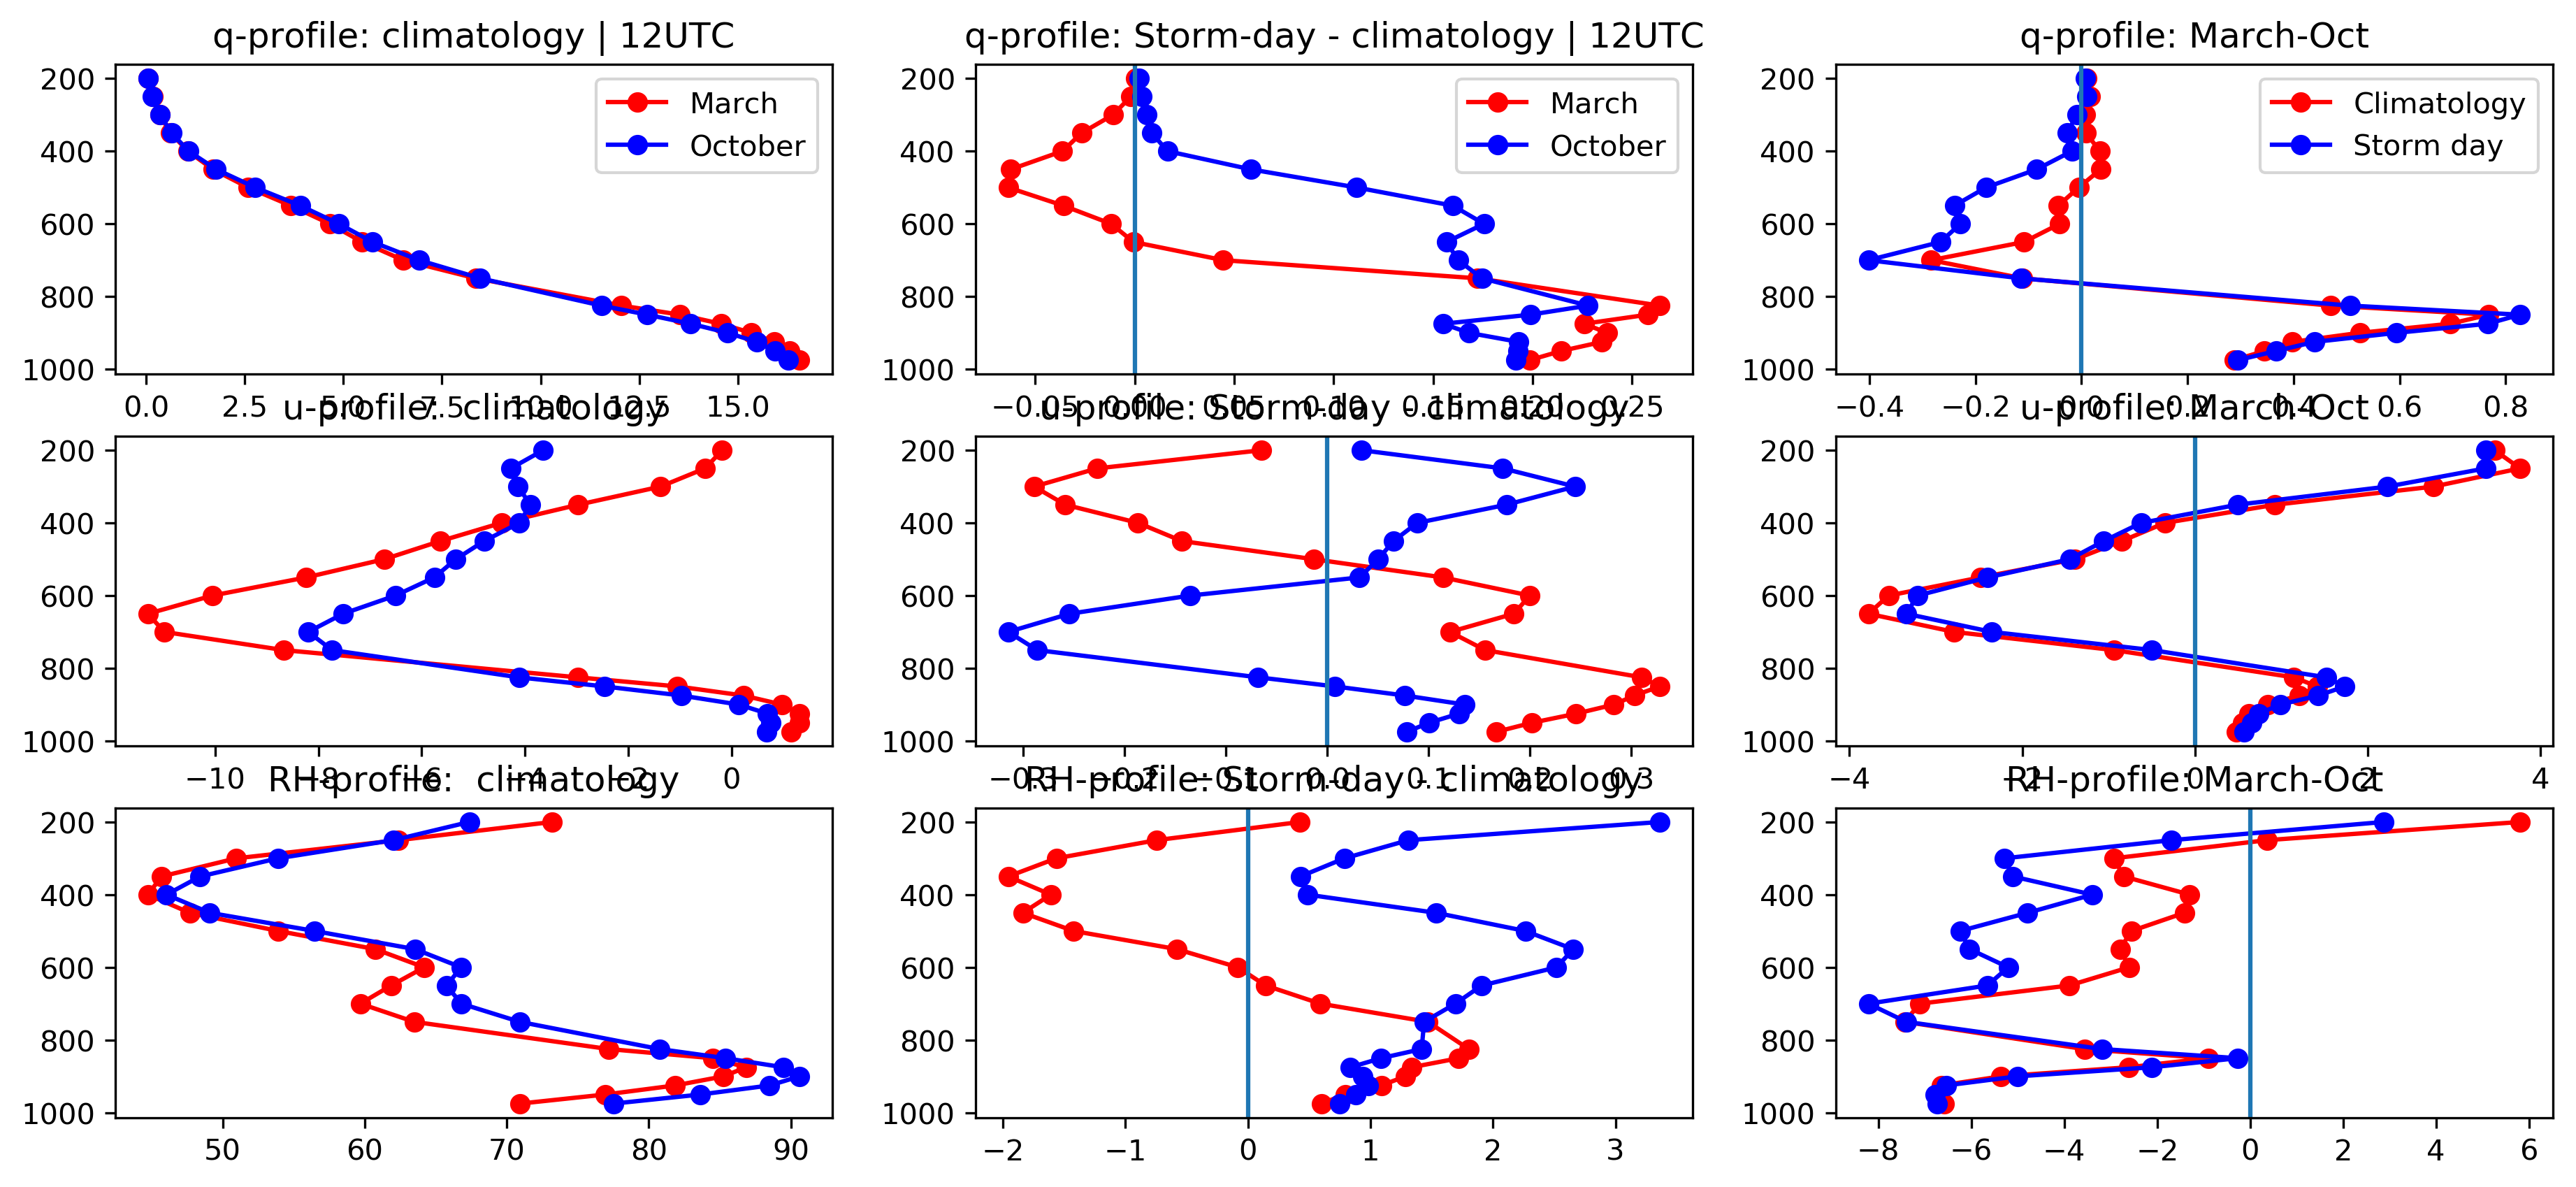

In [100]:
q_march =  np.array(era_march['q_col']).mean(axis=0)*1000 
q_oct =  np.array(era_oct['q_col']).mean(axis=0)*1000 
print(q_march.shape)
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(431)

plt.plot(q_march.squeeze(), level,'ro-', label='March')
plt.plot(q_oct.squeeze(), level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: climatology | 12UTC')
plt.legend()

q_march =  np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(434)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  climatology')

q_march = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_oct['q_col']).mean(axis=0)*1000 - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 

f.add_subplot(432)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Storm-day - climatology | 12UTC')
plt.legend()

q_march = np.array(era_march['u_col']).mean(axis=0) - np.array(clim_march['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_oct['u_col']).mean(axis=0) - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
f.add_subplot(435)
plt.plot(q_march, level,'o-r', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Storm-day - climatology')


q_march = np.array(clim_march['q_col']).mean(axis=0).squeeze()*1000  - np.array(clim_oct['q_col']).mean(axis=0).squeeze()*1000 
q_oct = np.array(era_march['q_col']).mean(axis=0)*1000 - np.array(era_oct['q_col']).mean(axis=0)*1000
f.add_subplot(433)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(clim_march['u_col']).mean(axis=0).squeeze() - np.array(clim_oct['u_col']).mean(axis=0).squeeze()
q_oct = np.array(era_march['u_col']).mean(axis=0) - np.array(era_oct['u_col']).mean(axis=0)
f.add_subplot(436)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct =  np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(437)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = np.array(era_march[sstr]).mean(axis=0) - np.array(clim_march[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_oct[sstr]).mean(axis=0) - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
f.add_subplot(438)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(439)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

################

sstr = 't_col'

q_march =  u_met.theta(level, np.array(clim_march[sstr]).mean(axis=0).squeeze())
q_oct =  u_met.theta(level, np.array(clim_oct[sstr]).mean(axis=0).squeeze())
f.add_subplot(4,3,10)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  climatology')

q_march = u_met.theta(level,np.array(era_march[sstr]).mean(axis=0)) - \
            u_met.theta(level,np.array(clim_march[sstr]).mean(axis=0).squeeze())
q_oct = u_met.theta(level, np.array(era_oct[sstr]).mean(axis=0)) - \
             u_met.theta(level,np.array(clim_oct[sstr]).mean(axis=0).squeeze())
f.add_subplot(4,3,11)
plt.plot(q_march, level,'ro-', label='March')
plt.plot(q_oct, level,'bo-', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Storm-day - climatology')

q_march = np.array(clim_march[sstr]).mean(axis=0).squeeze() - np.array(clim_oct[sstr]).mean(axis=0).squeeze()
q_oct = np.array(era_march[sstr]).mean(axis=0) - np.array(era_oct[sstr]).mean(axis=0)
f.add_subplot(4,3,12)
plt.plot(q_march, level,'ro-', label='Climatology')
plt.plot(q_oct, level,'bo-', label='Storm day')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')


plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles.png')

In [101]:
era_pl.level.values

array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800,
       850, 900, 925, 950], dtype=int32)

In [102]:
mar_strong['q_col'].shape

(458, 19)

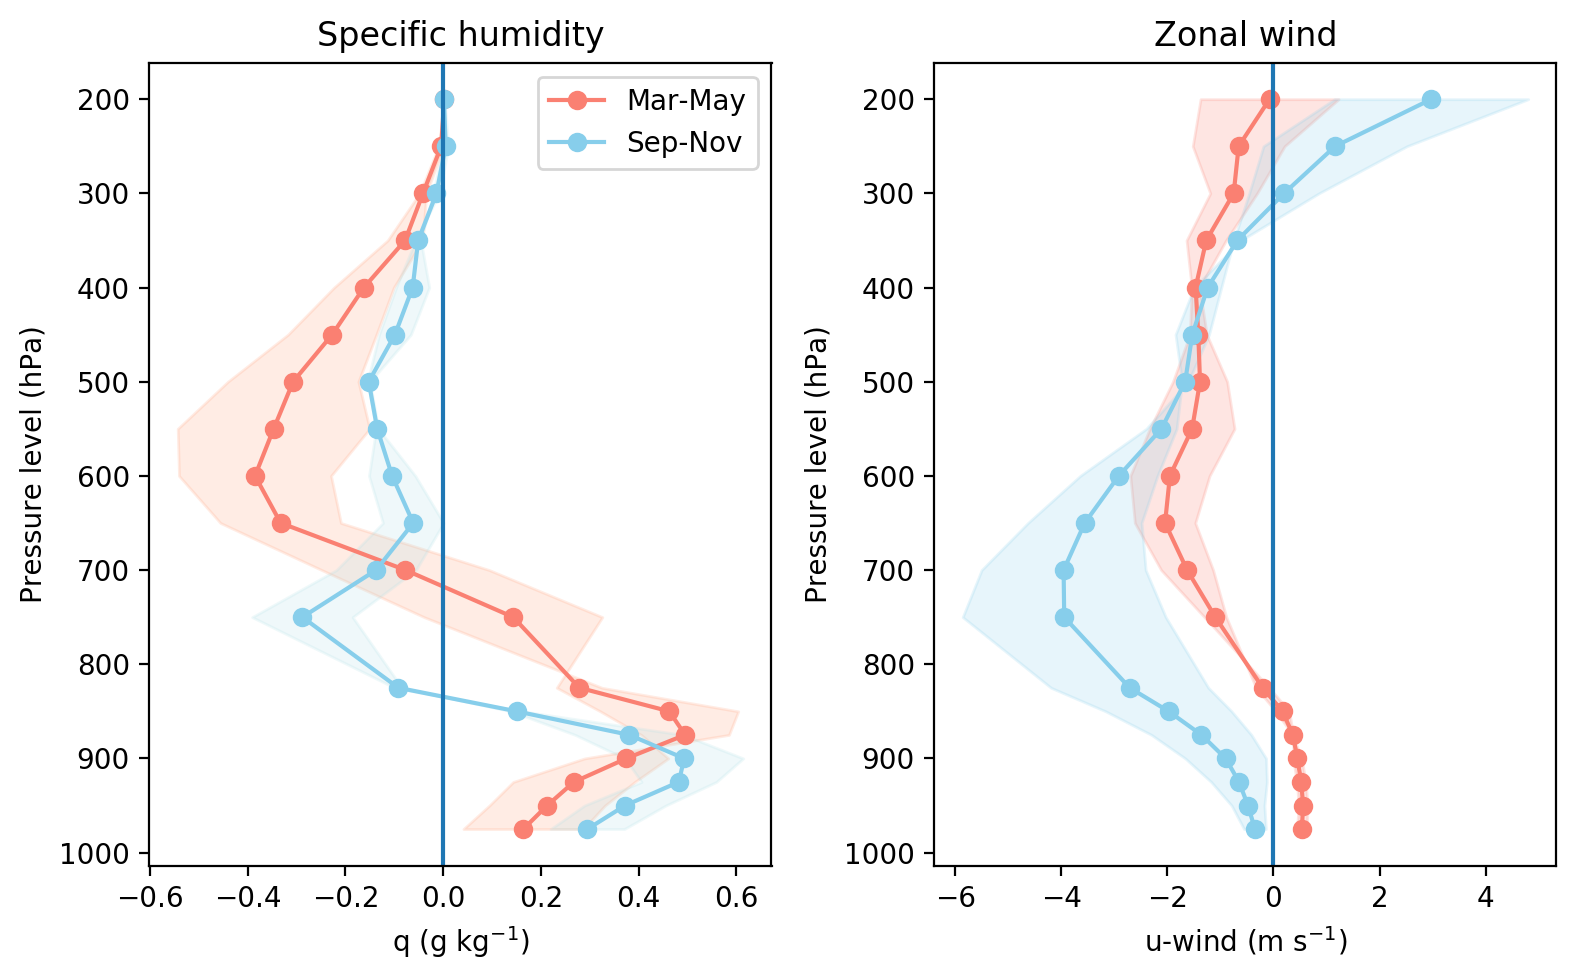

In [118]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(8,5), dpi=200)


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(121)
plt.plot(q_march,level,'-o', label='Mar-May', color='salmon')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, color='lightsalmon', alpha=0.2)
plt.plot(q_oct,level,'-o', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, alpha=0.2, color='powderblue')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.ylabel('Pressure level (hPa)')
plt.xlabel('q (g kg$^{-1})$')
plt.title('Specific humidity')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)

q_march_std = np.array(mar_strong['u_col']).std(axis=0) - np.array(mar_weak['u_col']).std(axis=0) 
q_oct_std = np.array(oct_strong['u_col']).std(axis=0) - np.array(oct_weak['u_col']).std(axis=0)

f.add_subplot(122)
plt.plot(q_march, level,'o-', label='Mar-May', color='salmon')
plt.plot(q_oct, level,'o-', label='Sep-Nov', color='skyblue')
plt.fill_betweenx(level, q_march+q_march_std, x2=q_march-q_march_std, alpha=0.2, color='salmon')

plt.fill_betweenx(level, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='skyblue', alpha=0.2)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel('u-wind (m s$^{-1})$')
plt.gca().invert_yaxis()
plt.title('Zonal wind')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

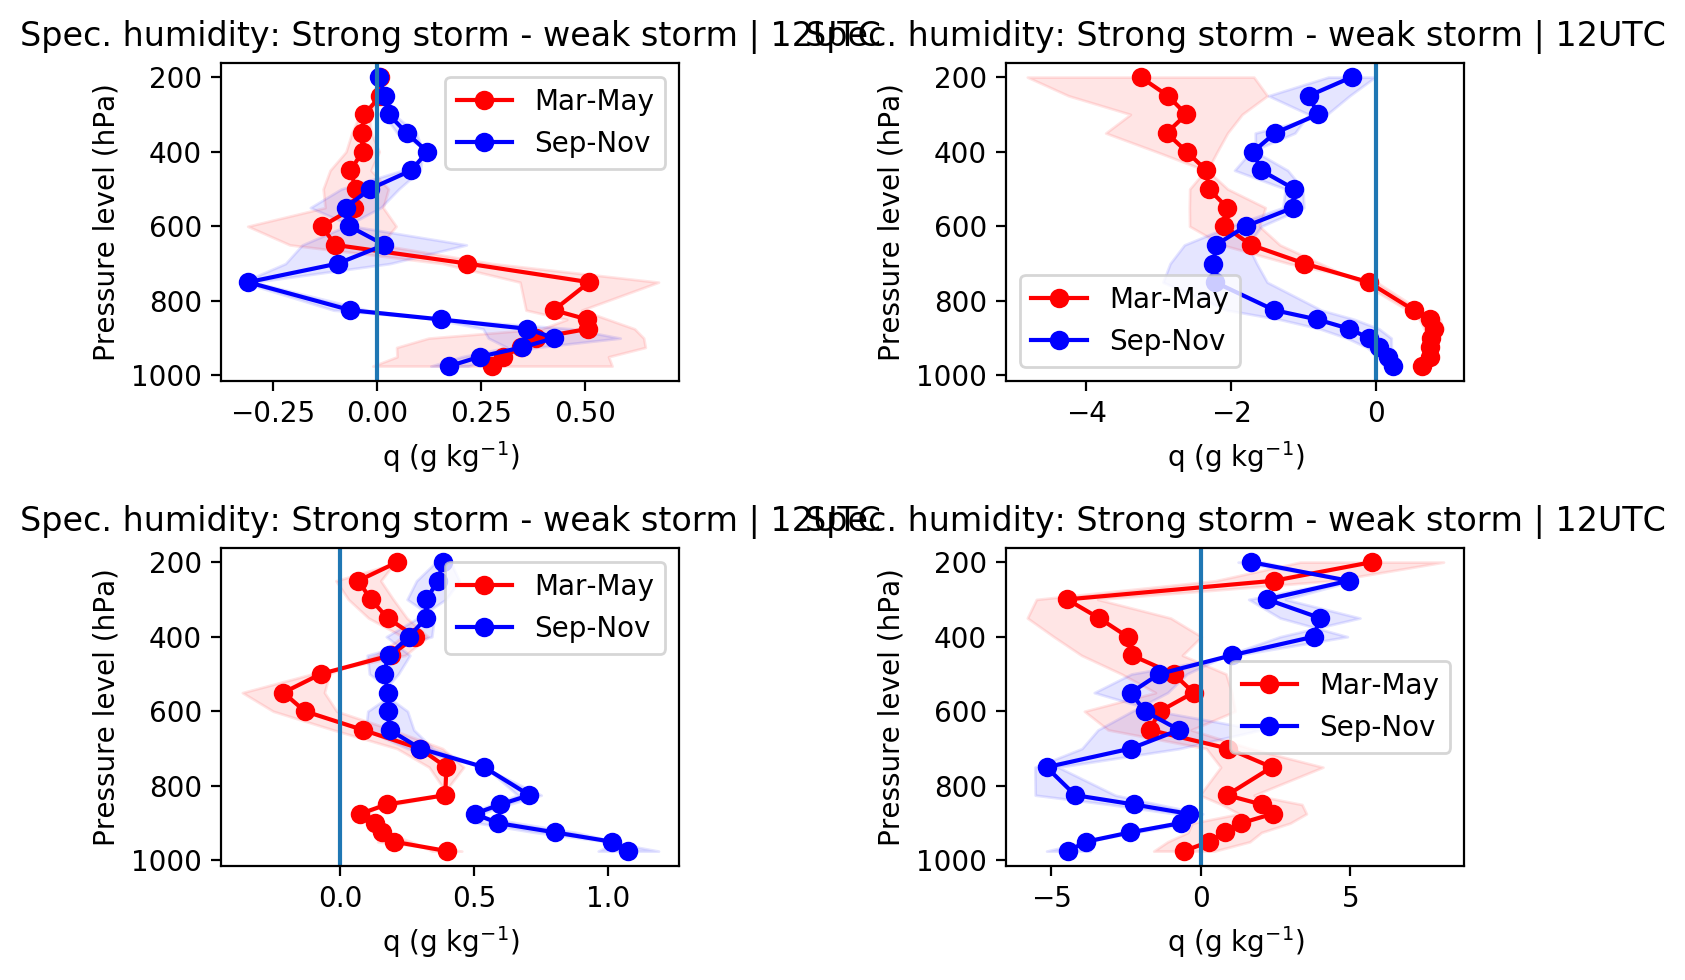

In [28]:
varss = [('q_col', 1000, ''), ('u_col', 1), ('t_col',1), ('r_col', 1)]

f = plt.figure(figsize=(8,5), dpi=200)

for ids, v in enumerate(varss):
    ax = f.add_subplot(2,2,ids+1)

    q_march = np.array(mar_strong[v[0]]).mean(axis=0)*v[1] - np.array(mar_weak[v[0]]).mean(axis=0)*v[1]
    q_oct = np.array(oct_strong[v[0]]).mean(axis=0)*v[1] - np.array(oct_weak[v[0]]).mean(axis=0)*v[1]

    q_march_std = np.array(mar_strong[v[0]]).std(axis=0)*v[1] - np.array(mar_weak[v[0]]).std(axis=0)*v[1] 
    q_oct_std = np.array(oct_strong[v[0]]).std(axis=0)*v[1] - np.array(oct_weak[v[0]]).std(axis=0)*v[1] 

    plt.plot(q_march, era_pl.level.values,'r-o', label='Mar-May')

    plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
    plt.plot(q_oct, era_pl.level.values,'b-o', label='Sep-Nov')
    plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
    plt.axvline(x=0)
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure level (hPa)')
    plt.xlabel('q (g kg$^{-1})$')
    plt.title('Spec. humidity: Strong storm - weak storm | 12UTC')
    plt.legend()


plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

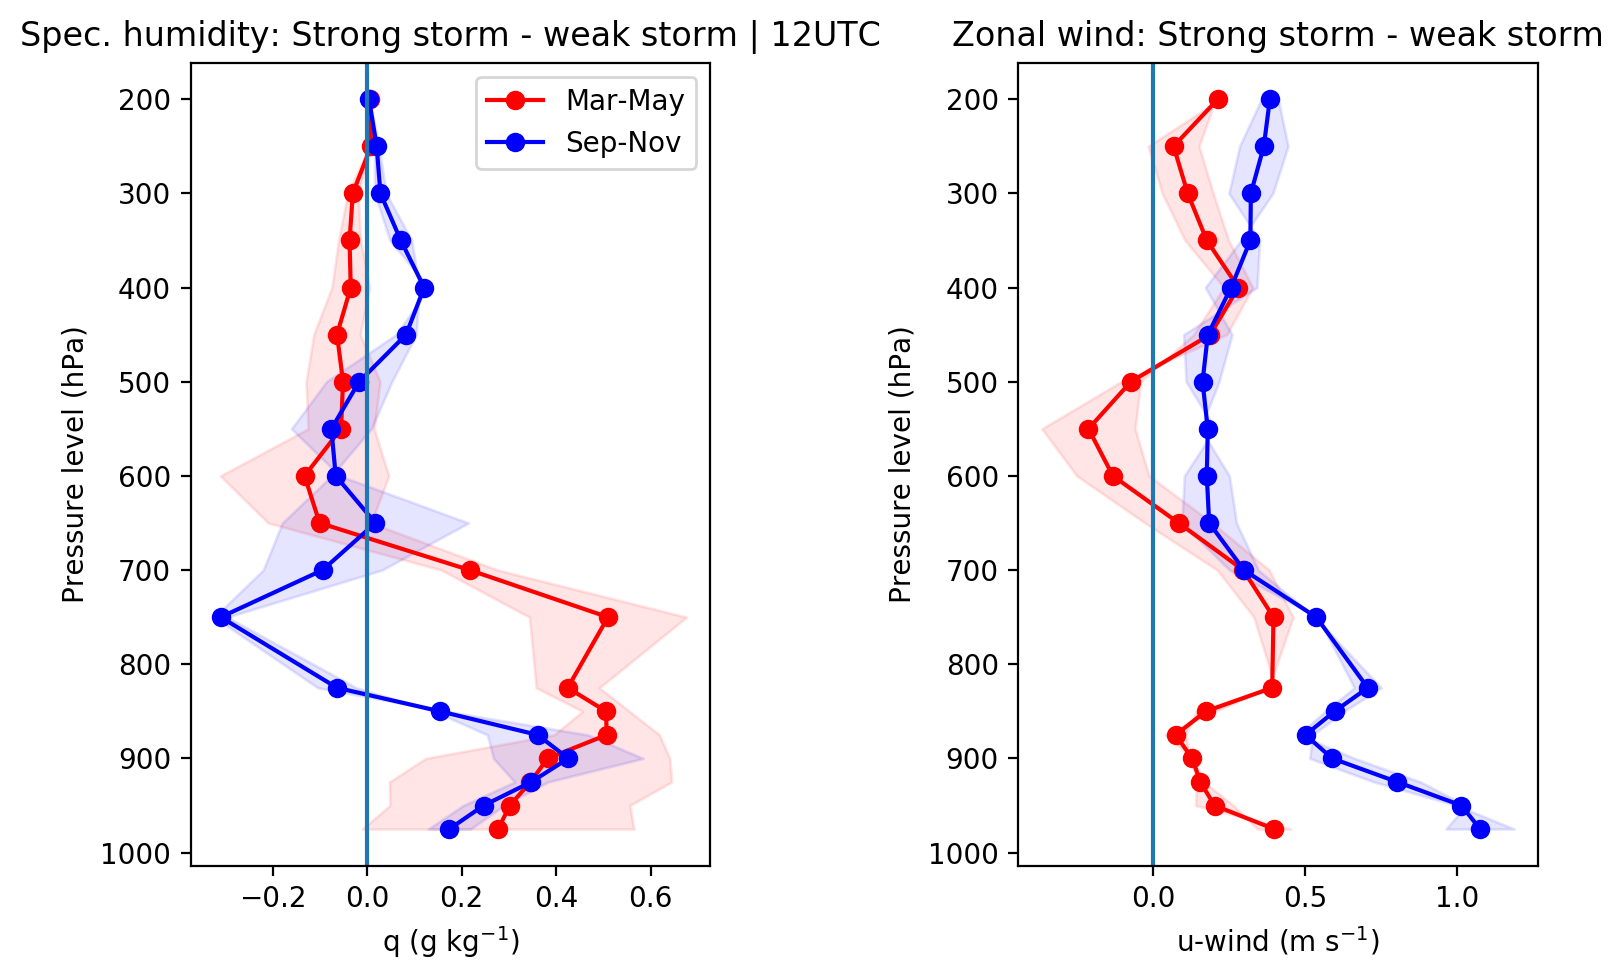

In [29]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(8,5), dpi=200)


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 
# q_march_25 = (np.percentile(np.array(mar_strong['q_col']), 25, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 25, axis=0))*1000

# q_march_75 = (np.percentile(np.array(mar_strong['q_col']), 75, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 75, axis=0))*1000

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(121)
plt.plot(q_march, era_pl.level.values,'r-o', label='Mar-May')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
plt.plot(q_oct, era_pl.level.values,'b-o', label='Sep-Nov')
plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.ylabel('Pressure level (hPa)')
plt.xlabel('q (g kg$^{-1})$')
plt.title('Spec. humidity: Strong storm - weak storm | 12UTC')
plt.legend()

q_march = np.array(mar_strong['t_col']).mean(axis=0) - np.array(mar_weak['t_col']).mean(axis=0)
q_oct = np.array(oct_strong['t_col']).mean(axis=0) - np.array(oct_weak['t_col']).mean(axis=0)

q_march_std = np.array(mar_strong['t_col']).std(axis=0) - np.array(mar_weak['t_col']).std(axis=0) 
q_oct_std = np.array(oct_strong['t_col']).std(axis=0) - np.array(oct_weak['t_col']).std(axis=0)

f.add_subplot(122)
plt.plot(q_march, era_pl.level.values,'ro-', label='Mar-May')
plt.plot(q_oct, era_pl.level.values,'bo-', label='Sep-Nov')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)

plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.ylabel('Pressure level (hPa)')
plt.xlabel('u-wind (m s$^{-1})$')
plt.gca().invert_yaxis()
plt.title('Zonal wind: Strong storm - weak storm')

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak_small.png')

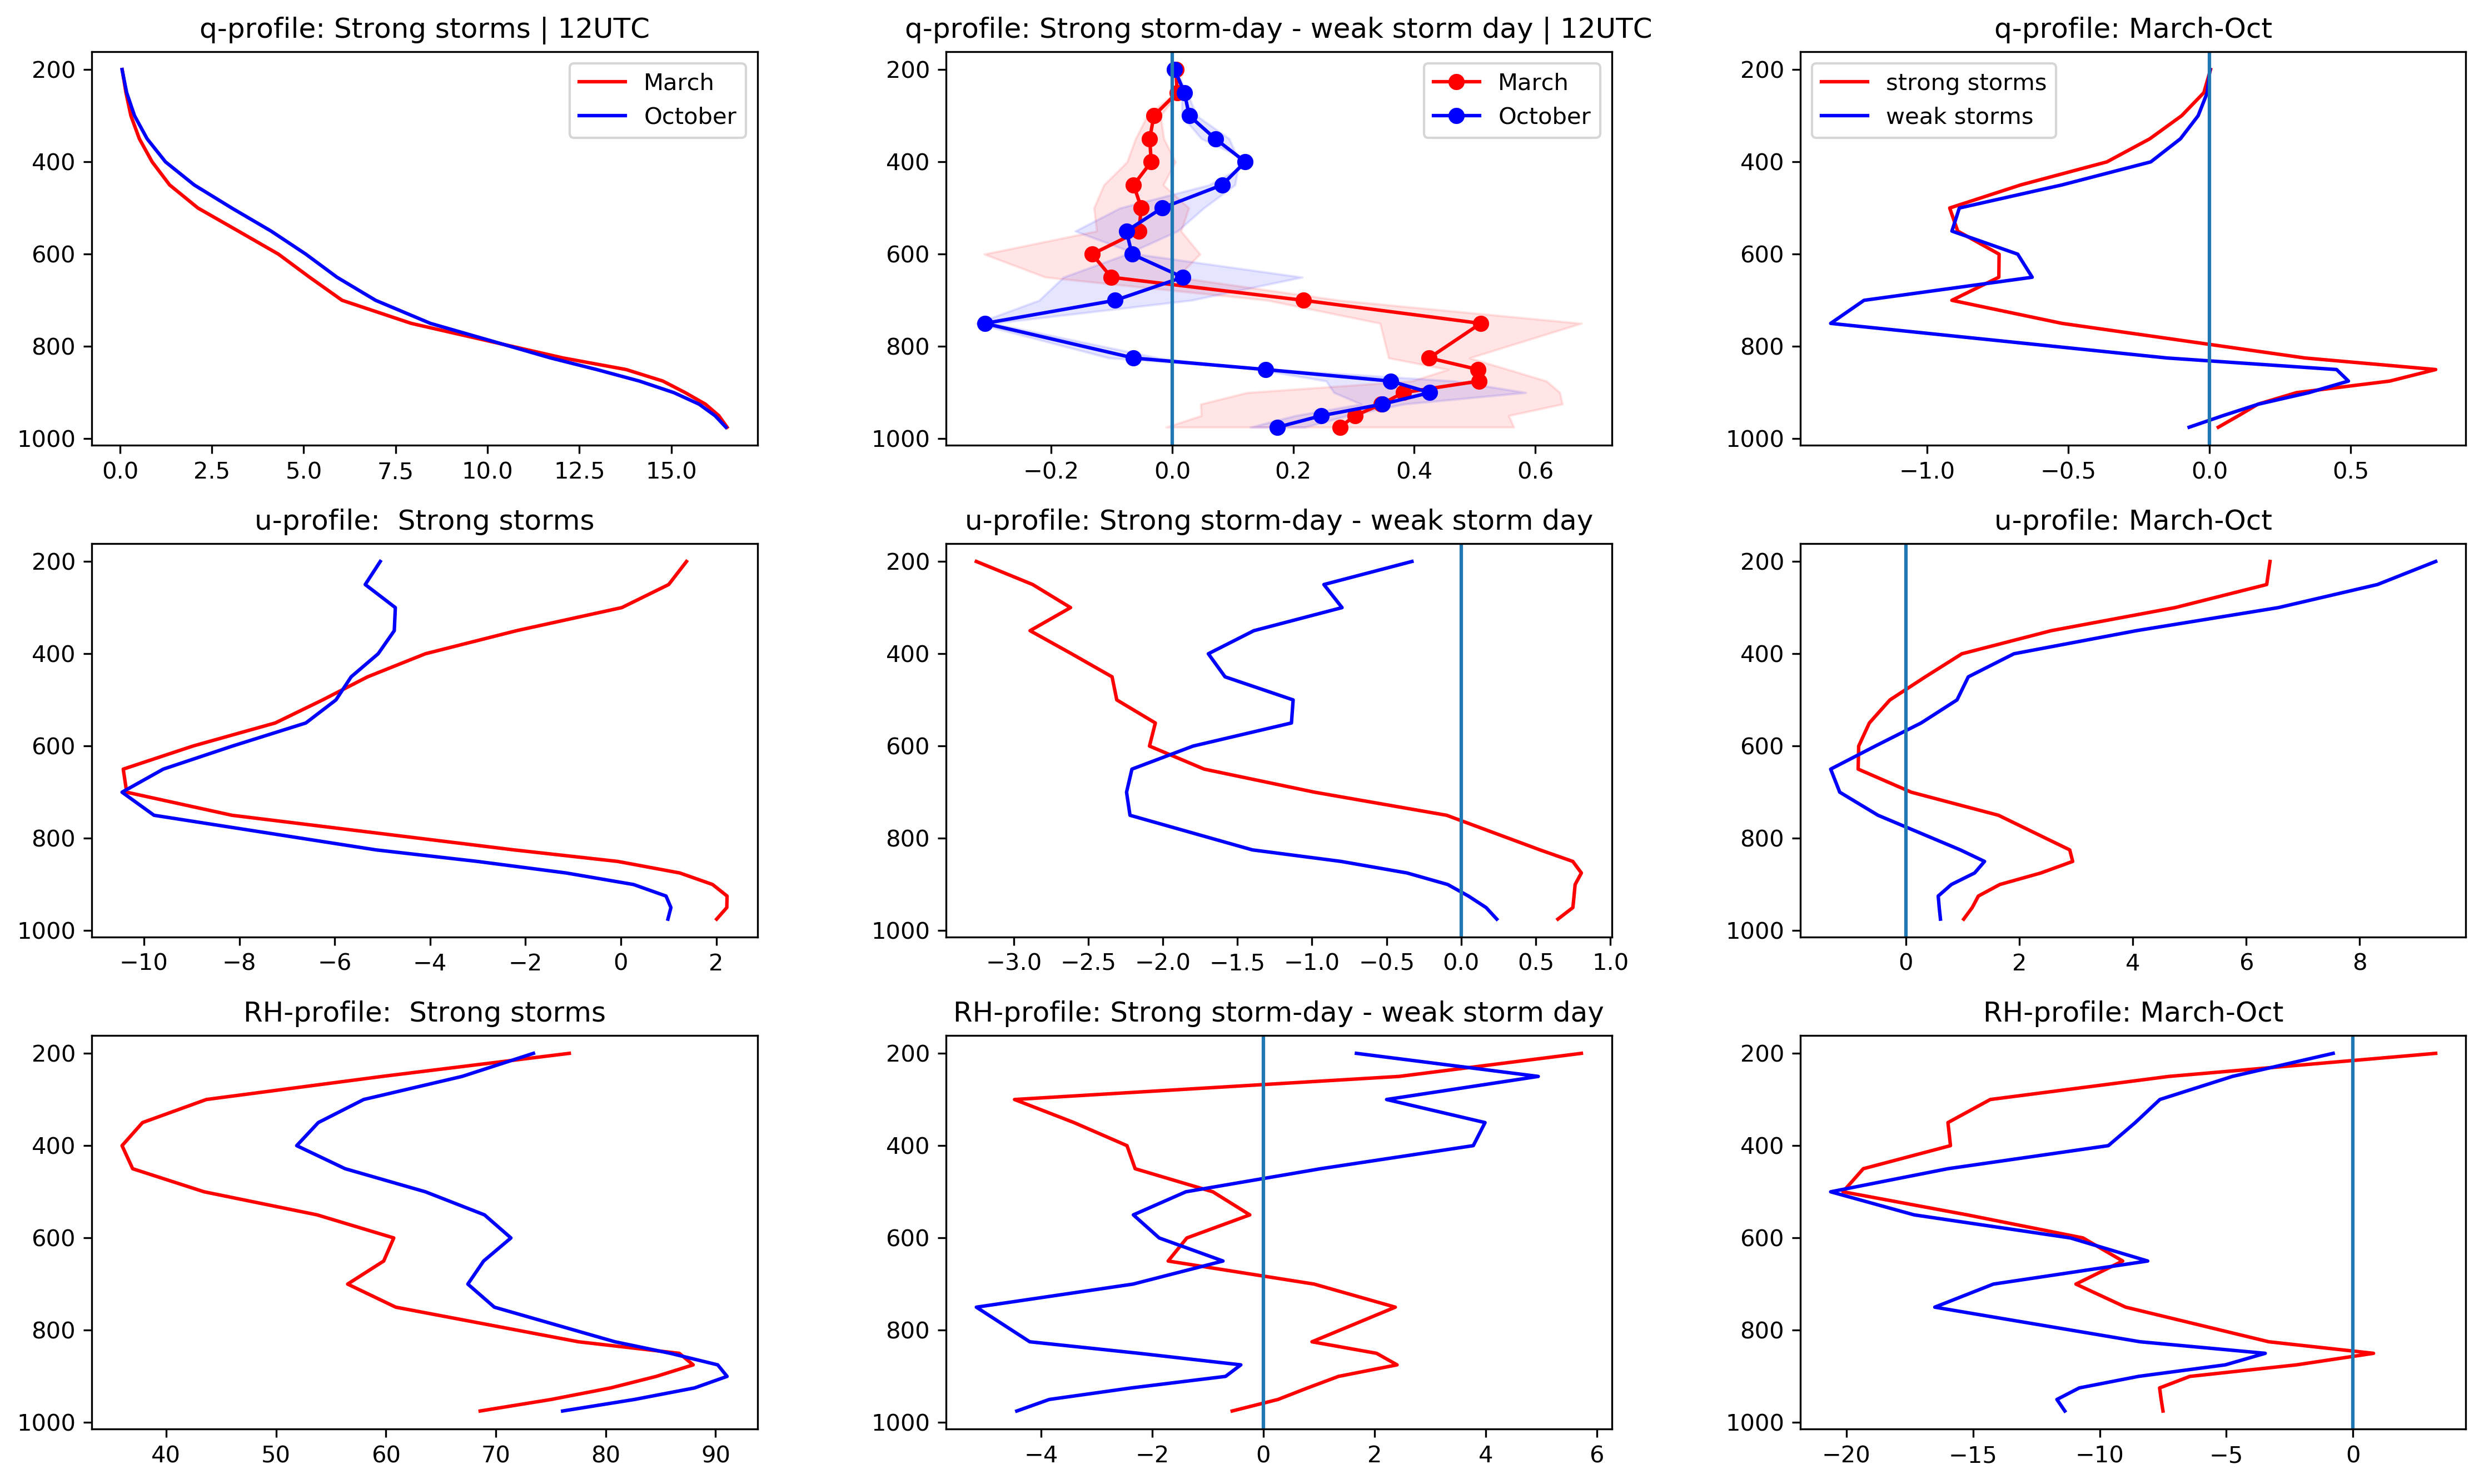

In [30]:
q_march =  np.array(mar_strong['q_col']).mean(axis=0)*1000 
q_oct =  np.array(oct_strong['q_col']).mean(axis=0)*1000 
f = plt.figure(figsize=(15,9), dpi=300)
f.add_subplot(331)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storms | 12UTC')
plt.legend()

q_march =  np.array(mar_strong['u_col']).mean(axis=0)
q_oct =  np.array(oct_strong['u_col']).mean(axis=0)
f.add_subplot(334)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile:  Strong storms')

q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000 - np.array(mar_weak['q_col']).mean(axis=0)*1000 
q_oct = np.array(oct_strong['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000 
# q_march_25 = (np.percentile(np.array(mar_strong['q_col']), 25, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 25, axis=0))*1000

# q_march_75 = (np.percentile(np.array(mar_strong['q_col']), 75, axis=0) - \
#             np.percentile(np.array(mar_weak['q_col']), 75, axis=0))*1000

q_march_std = np.array(mar_strong['q_col']).std(axis=0)*1000 - np.array(mar_weak['q_col']).std(axis=0)*1000 
q_oct_std = np.array(oct_strong['q_col']).std(axis=0)*1000 - np.array(oct_weak['q_col']).std(axis=0)*1000 

f.add_subplot(332)
plt.plot(q_march, era_pl.level.values,'r-o', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
# plt.plot(q_march_25, era_pl.level.values,'r.', label='March')
plt.fill_betweenx(era_pl.level.values, q_march+q_march_std, x2=q_march-q_march_std, color='r', alpha=0.1)
plt.plot(q_oct, era_pl.level.values,'b-o', label='October')
plt.fill_betweenx(era_pl.level.values, q_oct+q_oct_std, x2=q_oct-q_oct_std, color='b', alpha=0.1)
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: Strong storm-day - weak storm day | 12UTC')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(mar_weak['u_col']).mean(axis=0)
q_oct = np.array(oct_strong['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(335)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: Strong storm-day - weak storm day')


q_march = np.array(mar_strong['q_col']).mean(axis=0)*1000  - np.array(oct_strong['q_col']).mean(axis=0)*1000 
q_oct = np.array(mar_weak['q_col']).mean(axis=0)*1000 - np.array(oct_weak['q_col']).mean(axis=0)*1000
f.add_subplot(333)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('q-profile: March-Oct')
plt.legend()

q_march = np.array(mar_strong['u_col']).mean(axis=0) - np.array(oct_strong['u_col']).mean(axis=0)
q_oct = np.array(mar_weak['u_col']).mean(axis=0) - np.array(oct_weak['u_col']).mean(axis=0)
f.add_subplot(336)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('u-profile: March-Oct')

sstr = 'r_col'

q_march =  np.array(mar_strong[sstr]).mean(axis=0)
q_oct =  np.array(oct_strong[sstr]).mean(axis=0)
f.add_subplot(337)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
#plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile:  Strong storms')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(mar_weak[sstr]).mean(axis=0)
q_oct = np.array(oct_strong[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(338)
plt.plot(q_march, era_pl.level.values,'r', label='March')
plt.plot(q_oct, era_pl.level.values,'b', label='October')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: Strong storm-day - weak storm day')

q_march = np.array(mar_strong[sstr]).mean(axis=0) - np.array(oct_strong[sstr]).mean(axis=0)
q_oct = np.array(mar_weak[sstr]).mean(axis=0) - np.array(oct_weak[sstr]).mean(axis=0)
f.add_subplot(339)
plt.plot(q_march, era_pl.level.values,'r', label='strong storms')
plt.plot(q_oct, era_pl.level.values,'b', label='weak storms')
plt.axvline(x=0)
plt.gca().invert_yaxis()
plt.title('RH-profile: March-Oct')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/uRHq_profiles_strongWeak.png')

(array([1.063e+03, 3.610e+02, 1.550e+02, 1.100e+02, 6.000e+01, 4.900e+01,
        3.400e+01, 1.900e+01, 1.900e+01, 1.700e+01, 1.600e+01, 8.000e+00,
        8.000e+00, 3.000e+00, 9.000e+00, 6.000e+00, 3.000e+00, 3.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([  5039.65      ,  13385.70566667,  21731.76133333,  30077.817     ,
         38423.87266667,  46769.92833333,  55115.984     ,  63462.03966667,
         71808.09533333,  80154.151     ,  88500.20666667,  96846.26233333,
        105192.318     , 113538.37366667, 121884.42933333, 130230.485     ,
        138576.54066667, 146922.59633333, 155268.652     , 163614.70766667,
        171960.76333333, 180306.819     , 188652.87466667, 196998.93033333,
        205344.986     , 213691.04166667, 222037.09733333, 230383.153     ,
        238729.20866667, 247075.26433333, 255421.32      ]),
 <a list of 30 Patch objects>)

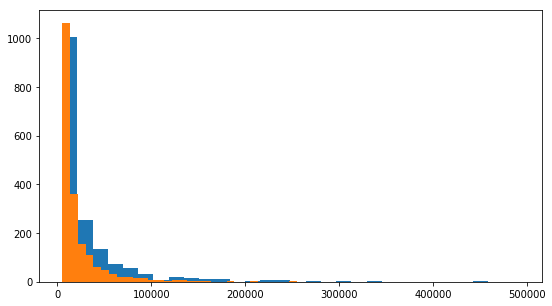

In [31]:
plt.figure(figsize=(9,5))
plt.hist(np.array(era_march['area']), bins=30)
plt.hist(np.array(era_oct['area']), bins=30)

In [32]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [33]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [34]:
era_pl_cross.ymonth

<xarray.DataArray 'ymonth' (ymonth: 96)>
array(['1-0', '1-12', '1-15', '1-18', '1-21', '1-3', '1-6', '1-9', '10-0',
       '10-12', '10-15', '10-18', '10-21', '10-3', '10-6', '10-9', '11-0',
       '11-12', '11-15', '11-18', '11-21', '11-3', '11-6', '11-9', '12-0',
       '12-12', '12-15', '12-18', '12-21', '12-3', '12-6', '12-9', '2-0',
       '2-12', '2-15', '2-18', '2-21', '2-3', '2-6', '2-9', '3-0', '3-12',
       '3-15', '3-18', '3-21', '3-3', '3-6', '3-9', '4-0', '4-12', '4-15',
       '4-18', '4-21', '4-3', '4-6', '4-9', '5-0', '5-12', '5-15', '5-18',
       '5-21', '5-3', '5-6', '5-9', '6-0', '6-12', '6-15', '6-18', '6-21',
       '6-3', '6-6', '6-9', '7-0', '7-12', '7-15', '7-18', '7-21', '7-3',
       '7-6', '7-9', '8-0', '8-12', '8-15', '8-18', '8-21', '8-3', '8-6',
       '8-9', '9-0', '9-12', '9-15', '9-18', '9-21', '9-3', '9-6', '9-9'],
      dtype=object)
Coordinates:
  * ymonth   (ymonth) object '1-0' '1-12' '1-15' '1-18' ... '9-3' '9-6' '9-9'

In [35]:
cross_march = era_pl_cross.sel(ymonth='3-12')
cross_oct = era_pl_cross.sel(ymonth='10-12')

In [36]:
era_pl_cross

<xarray.Dataset>
Dimensions:    (latitude: 87, level: 19, longitude: 143, ymonth: 96)
Coordinates:
  * longitude  (longitude) float64 -18.5 -18.25 -18.0 -17.75 ... 16.5 16.75 17.0
  * latitude   (latitude) float64 25.0 24.75 24.5 24.25 ... 4.25 4.0 3.75 3.5
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
  * ymonth     (ymonth) object '1-0' '1-12' '1-15' '1-18' ... '9-3' '9-6' '9-9'
Data variables:
    pv         (ymonth, level, latitude, longitude) float32 dask.array<shape=(96, 19, 87, 143), chunksize=(1, 19, 87, 143)>
    t          (ymonth, level, latitude, longitude) float32 dask.array<shape=(96, 19, 87, 143), chunksize=(1, 19, 87, 143)>
    q          (ymonth, level, latitude, longitude) float32 dask.array<shape=(96, 19, 87, 143), chunksize=(1, 19, 87, 143)>
    w          (ymonth, level, latitude, longitude) float32 dask.array<shape=(96, 19, 87, 143), chunksize=(1, 19, 87, 143)>
    d          (ymonth, level, latitude, longitude) float32 dask.arra

In [37]:
cross_march['t'].values-273.15

array([[[-55.47737  , -55.46904  , -55.462112 , ..., -53.398834 ,
         -53.37964  , -53.363068 ],
        [-55.408585 , -55.401825 , -55.395493 , ..., -53.357513 ,
         -53.343338 , -53.329254 ],
        [-55.337173 , -55.33229  , -55.32631  , ..., -53.31897  ,
         -53.309998 , -53.299286 ],
        ...,
        [-53.731735 , -53.730743 , -53.691925 , ..., -53.417328 ,
         -53.416885 , -53.41919  ],
        [-53.714478 , -53.714035 , -53.705307 , ..., -53.41394  ,
         -53.4198   , -53.419662 ],
        [-53.698807 , -53.69687  , -53.68959  , ..., -53.41429  ,
         -53.42395  , -53.423523 ]],

       [[-48.26062  , -48.27179  , -48.281616 , ..., -45.51483  ,
         -45.48477  , -45.457382 ],
        [-48.096237 , -48.11023  , -48.12332  , ..., -45.307144 ,
         -45.283447 , -45.262436 ],
        [-47.934097 , -47.949524 , -47.964096 , ..., -45.110962 ,
         -45.092285 , -45.0739   ],
        ...,
        [-41.468765 , -41.476013 , -41.42859  , ..., -

In [38]:
ccross_march = cross_march.sel(longitude=slice(-10,10)).mean('longitude')
ccross_oct = cross_oct.sel(longitude=slice(-10,10)).mean('longitude')

In [39]:
cross_march

<xarray.Dataset>
Dimensions:    (latitude: 87, level: 19, longitude: 143)
Coordinates:
  * longitude  (longitude) float64 -18.5 -18.25 -18.0 -17.75 ... 16.5 16.75 17.0
  * latitude   (latitude) float64 25.0 24.75 24.5 24.25 ... 4.25 4.0 3.75 3.5
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
    ymonth     <U4 '3-12'
Data variables:
    pv         (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), chunksize=(19, 87, 143)>
    t          (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), chunksize=(19, 87, 143)>
    q          (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), chunksize=(19, 87, 143)>
    w          (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), chunksize=(19, 87, 143)>
    d          (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), chunksize=(19, 87, 143)>
    r          (level, latitude, longitude) float32 dask.array<shape=(19, 87, 143), ch

In [40]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

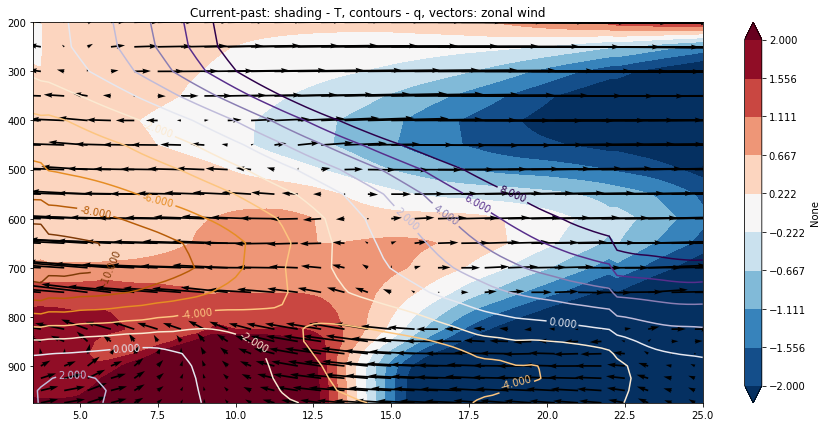

In [41]:
# temperature and moisture check
data = (ccross_march['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']-ccross_oct['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [42]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [43]:
(cross_march)['u']

<xarray.DataArray 'u' (level: 19, latitude: 87, longitude: 143)>
dask.array<shape=(19, 87, 143), dtype=float32, chunksize=(19, 87, 143)>
Coordinates:
  * longitude  (longitude) float64 -18.5 -18.25 -18.0 -17.75 ... 16.5 16.75 17.0
  * latitude   (latitude) float64 25.0 24.75 24.5 24.25 ... 4.25 4.0 3.75 3.5
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
    ymonth     <U4 '3-12'

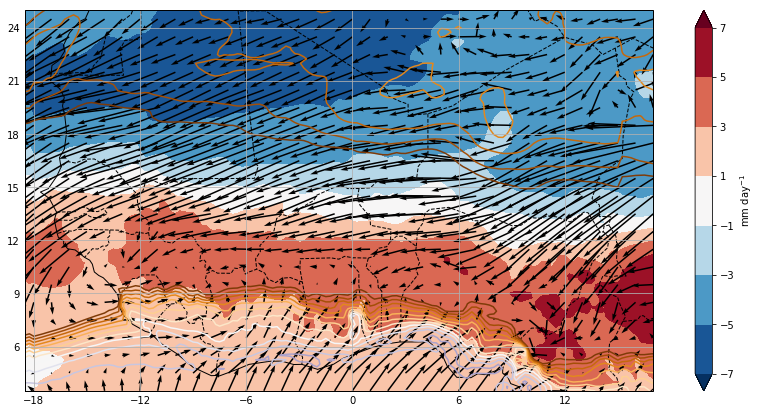

In [44]:
lon=cross_march.longitude
lat=cross_march.latitude
map_cross_march = cross_march.sel(level=925)
map_cross_oct = cross_oct.sel(level=925)
data=map_cross_march['t']-map_cross_oct['t']
data2=map_cross_march['q']-map_cross_oct['q']
title=''

contour = {'data' : data2*1000, 'x' : lon, 'y' : lat, 'levels' : np.arange(-3,3,0.4), 'cmap' : 'PuOr'}

# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = map_cross_march.longitude[sarrow::st]
yquiv = map_cross_march.latitude[sarrow::st]

uu = (map_cross_march['u'])[sarrow::st, sarrow::st]
vv = (map_cross_march['v'])[sarrow::st, sarrow::st]


qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}

draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', quiver=qin, cmap='RdBu_r', contour=contour, cbar_label= 'mm day$^{-1}$')


In [45]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'level'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [46]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_trend = era_pl.sel(longitude=slice(-10,10)).squeeze().mean('longitude')

FileNotFoundError: [Errno 2] No such file or directory: b'/home/ck/DIR/mymachine/GRIDSAT/MCS18/aggs/gridsat_WA_-70_monthly_count.nc'

In [ ]:
def trends_month(var):
    
    utrend = era_trend[var][(era_trend['time.year']>1982)].groupby('time.month').apply(linear_trend_lingress_2d,nb_missing=10, method='mk')*10
    
    return utrend

In [ ]:
utrend = trends_month('t')

In [ ]:
ccross_march['t'].values = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)

In [ ]:
ccross_march['t'].values

In [ ]:
# temperature and moisture check
data = (ccross_march['t'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.linspace(data.min(),data.max(),10), 'cmap' : 'PuOr'}
draw_cross(utrend.sel(month=3), utrend.latitude, utrend.level, cmap='RdBu_r', contour=contour,
           levels=np.linspace(-0.5,0.5,10), title='Current-past: shading - T, contours - q, vectors: zonal wind')